#Libraries

In [ ]:
#from google.colab import drive
#import os

#data processing
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA

# Machine learning models; some may not be used just placed here in case for future use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# model evaluation and hyperparameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axes

# statistic tests
import operator
from scipy.stats import f, t

import warnings 
warnings.filterwarnings('ignore')

#Data Loadsing and Standardizing

In [1]:
age = df['Age'].values
age.sort()
age

NameError: ignored

In [ ]:
#drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/MyDrive/Colab Notebooks/DATA_MECHEN/MECHEN_FINAL_PROJECT')
#df = pd.read_csv('Heart_Disease_Prediction.csv')
df = pd.read_csv('https://raw.githubusercontent.com/alien101/MECEE4520/main/Heart_Disease_Prediction.csv')
df['Heart Disease'] = df['Heart Disease'].map({'Absence': 0, 'Presence': 1})
X = df[df.columns[:-1]].values
Y = df[df.columns[-1]].values
print(df.shape)
scaled_X = (X - np.mean(X, axis = 0)) / np.std(X, axis = 0)

temp = np.array(Y).reshape(-1, 1)
scaled_data = np.append(scaled_X, temp, axis = 1)
scaled_df = pd.DataFrame(scaled_data, columns = df.columns)
df.head()

#Data Cleaning: Outlier and PCA

In [ ]:
# Check if there is any null data
scaled_df.apply(lambda x: sum(x.isnull()),axis=0)

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

In [ ]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

find_outliers_IQR(df)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
1,NaN,NaN,NaN,NaN,564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,NaN,NaN,NaN,172.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# source: https://colab.research.google.com/drive/1c-e1Xf89DRuvEW67SchWlI0iQc7wrXis#scrollTo=Qe4feuF4kRFI
def outliers(data, n, specs):
    out_i = []
    for col in specs:
        quar1 = np.percentile(data[col],25)
        quar3 = np.percentile(data[col],75)
        quar = quar3 - quar1
        outlier_step = 1.5 * quar 
        outlier_list_col = data[(data[col] < quar1 - outlier_step) | (data[col] > quar3 + outlier_step)].index
        out_i.extend(outlier_list_col) 
    out_i = Counter(out_i)
    multiple_outliers = list(key for key, value in out_i.items() if value > n) 
    return multiple_outliers
# Necessary to remove outliers? 
outliers_to_drop = outliers(scaled_df, 2, scaled_df.columns)
# df2: df with removed one outlier (269, 14)

In [ ]:
values = scaled_df.iloc[87]
interval = []
for col in scaled_df.columns:
        quar1 = np.percentile(scaled_df[col],25)
        quar3 = np.percentile(scaled_df[col],75)
        quar = quar3 - quar1
        outlier_step = 1.5 * quar
        interval.append([quar1 - outlier_step, quar3 + outlier_step])
c = 0   
for l, u in interval:
  if values[c] > u or  values[c] < l:
    print(scaled_df.columns[c])
  c += 1

Chest pain type
BP
ST depression


In [ ]:
scaled_df = scaled_df.drop(outliers_to_drop, axis = 0).reset_index(drop = True)

scaled_X = scaled_df[scaled_df.columns[:-1]].values
Y = scaled_df[scaled_df.columns[-1]].values

scaled_df.shape
outliers(df, 2, scaled_df.columns)

[87]

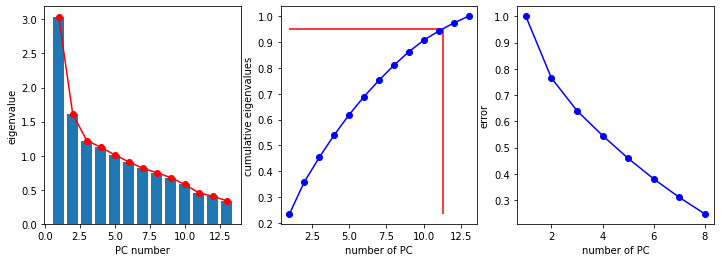

In [ ]:
'''
PCA to clean data before proceesing to model
'''
fig, ax = plt.subplots(1,3)
fig.set_size_inches(12, 4)

n = len(scaled_X)
# scaled_X.T @ scaled_X / n is the covariance matrix of scaled_X
U, S, Vh = np.linalg.svd(scaled_X.T @ scaled_X / n)

errors = []
for i in range(8):
  U_reduced = U[:, :i]
  Z = scaled_X @ U_reduced
  X_approx = Z @ U_reduced.T
  error = np.sum(np.square(np.linalg.norm(scaled_X - X_approx, ord = 2, axis = 1))) / np.sum(np.square(np.linalg.norm(scaled_X, ord = 2, axis = 1)))
  errors.append(error)

pca = PCA()
pca.fit(scaled_X)
evr_cum = np.cumsum(pca.explained_variance_ratio_)
#evr_cum = np.cumsum(S) doesn't scaled to percentage
# threshold will be: 90% variance explained with x variables => 0.9 = sum(lambda)/ x 

# percent of coverage
a = 0.95 
m = 0
for i in range(8):
  if evr_cum[i] >= a:
    print("Need %d vectors for at least 90%% coverage" %(i+1))
    m = i+1
    break

ax[0].set_ylabel("eigenvalue")
ax[0].set_xlabel("PC number")
ax[0].plot(np.linspace(1, len(S), len(S)), S , 'ro-')
ax[0].bar([ i +1 for i in range(len(S))], S)
ax[1].set_ylabel("cumulative eigenvalues")
ax[1].set_xlabel("number of PC")

ax[1].hlines(y = a, xmin = 1, xmax = 11.3, color='r')
ax[1].vlines(x = 11.3, ymin = np.min(evr_cum), ymax = a ,color='r')

ax[1].plot(np.linspace(1, len(evr_cum), len(evr_cum)), evr_cum, 'bo-')
ax[2].set_ylabel("error")
ax[2].set_xlabel("number of PC")
ax[2].plot(np.linspace(1, len(errors), len(errors)), errors, 'bo-')


#Data Visualization

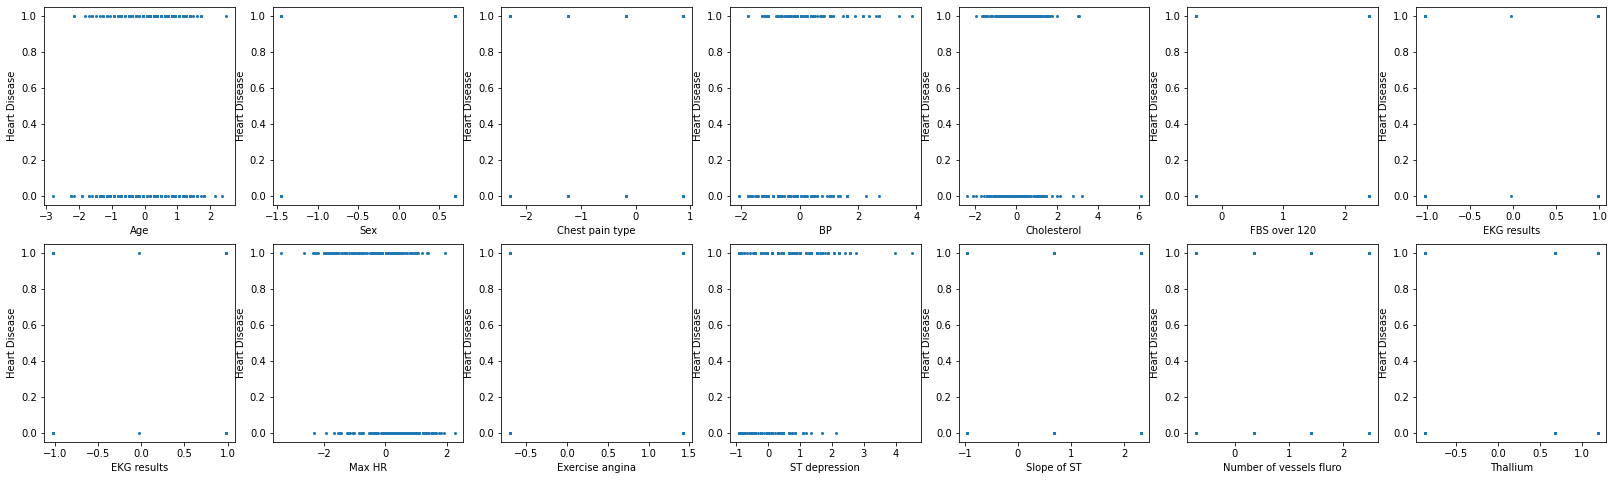

In [ ]:
# Data visualization
fig, ax = plt.subplots(2, 7)
fig.set_size_inches(28, 8)
f_names = df.columns
for i in range(2):
  for j in range(7):
    col = i*6 +j
    ax[i, j].set_xlabel(f_names[col])
    ax[i, j].set_ylabel(f_names[-1])
    ax[i, j].scatter(scaled_X[: ,col], Y, s = 4)

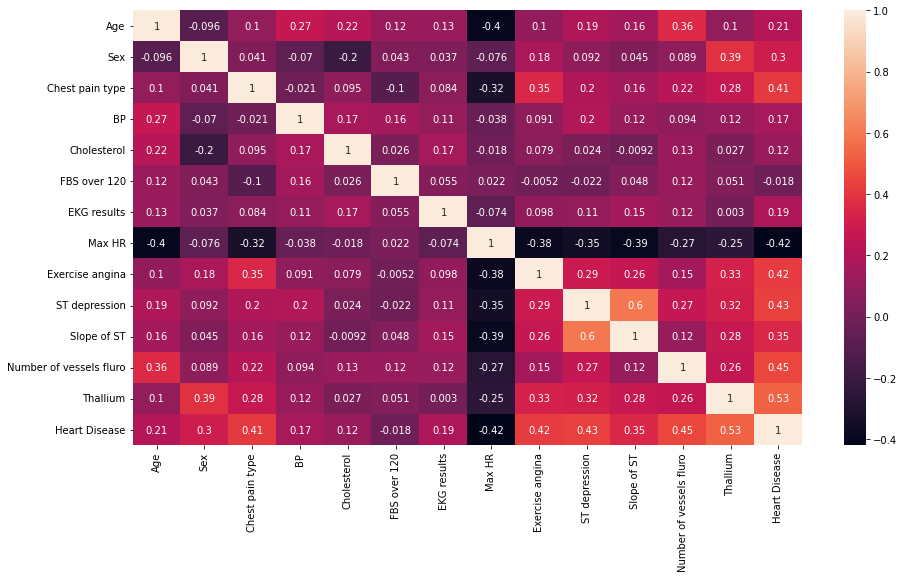

In [ ]:
corr_matrix = scaled_df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True)

#Cross-Validation Methods: K-Fold with ANOVA and t-test

In [ ]:
# F test with equal sample size
def f_test(xs, n):
  
  means = xs['Cross Validation Mean'].values
  stds = xs['Cross Validation Std'].values
  m = len(means)
  
  swith2 = np.sum(np.square(stds))/ m
  sbet2 = n* np.sum(np.square(means - (np.sum(means)/m)))/(m - 1)
  F = sbet2/swith2
  q = 0.05
  dfn = m - 1
  dfd = m*(n - 1)
  fcrit = f.ppf(q, dfn, dfd)
  
  if fcrit < F:
    return True
  else:
    return False

In [ ]:
# t test with equal sample size in holm sidak correction
def t_test(xs, n):
  
  means = xs['Cross Validation Mean'].values
  stds = xs['Cross Validation Std'].values
  m = len(means)
  ts = {}
  for i in range(len(means)):
    for j in range(len(means)):
      if i == j:
         continue
      swith2 = (stds[i]**2 + stds[j]**2) /2
      T = abs(means[i] - means[j])/ np.sqrt(2* swith2 /n)
      ts.update({(min(i, j), max(i, j)): T})

  ts = dict(sorted(ts.items(), key = operator.itemgetter(1),reverse=True))
  
  a = 0.05
  df = m*(n-1)
  pairs = []
  j = 0
  for i, pair in zip(ts.values(), ts.keys()):
    q = 1 - (1-a)**(1/ (len(ts) - j + 1))
    tcrit = t.ppf(q, df)
    j += 1
    if tcrit < i:
      pairs.append(pair)
    else:
      break
  if len(pairs) == len(ts):
    print('T-test: All significant')
  else:
    print('T-test: %d out of %d paris are significant' %(len(pairs), len(ts)))
  return pairs

ANOVA: Difference is Significant
T-test: All significant


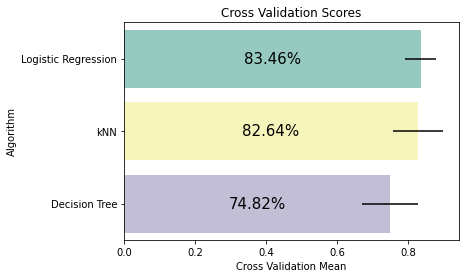

In [ ]:
fig.set_size_inches(8, 16)

classifiers = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier()]

# split data to train, validation, test sets
train_x, test_x, train_y, test_y = train_test_split(scaled_X, Y, test_size = 0.1, random_state = 0)
cvs = []
for classifier in classifiers:
    cvs.append(cross_val_score(classifier, train_x, train_y, scoring = 'accuracy', cv = 9))

cvs_mean = []
cvs_std = []

for cv in cvs:
    cvs_mean.append(cv.mean())
    cvs_std.append(cv.std())

cv_res = pd.DataFrame({'Cross Validation Mean': cvs_mean, 'Cross Validation Std': cvs_std, 'Algorithm': ['Logistic Regression', 'Decision Tree', 'kNN']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

if f_test(cv_res, train_x.shape[0]// 9):
  print('ANOVA: Difference is Significant')

t_test(cv_res, train_x.shape[0]// 9)
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cvs_std})
#plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

new2 = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Cross Validation Mean']
c = 0
for i in new2:
  plt.annotate((str(round(i*100, 2)) +'%'), xy=(i/2, c+0.1), ha='center', va='bottom', fontsize = 15)
  c += 1

    

In [ ]:
log_model = LogisticRegression()
log_model.fit(train_x, train_y)

log_yhat = log_model.predict(test_x)
c = 0
n = len(test_y)
for i in range(n):
  if log_yhat[i] == test_y[i]:
    c += 1
log_all_accu = c/n*100
print('Logistic Model Accuracy: %.2f %%' %log_all_accu)

log_model.score(test_x, test_y)

Logistic Model Accuracy: 85.19 %


0.8518518518518519

In [ ]:
accuracy = {}
for i in range(len(scaled_df.columns) - 1):

    train = np.delete(train_x, i , 1)
    test = np.delete(test_x, i , 1)
   
    log = LogisticRegression()
    log.fit(train, train_y)
    yhat = log.predict(test)
    score = log.score(test, test_y)

    accuracy[scaled_df.columns[i]] = round(score*100, 2)

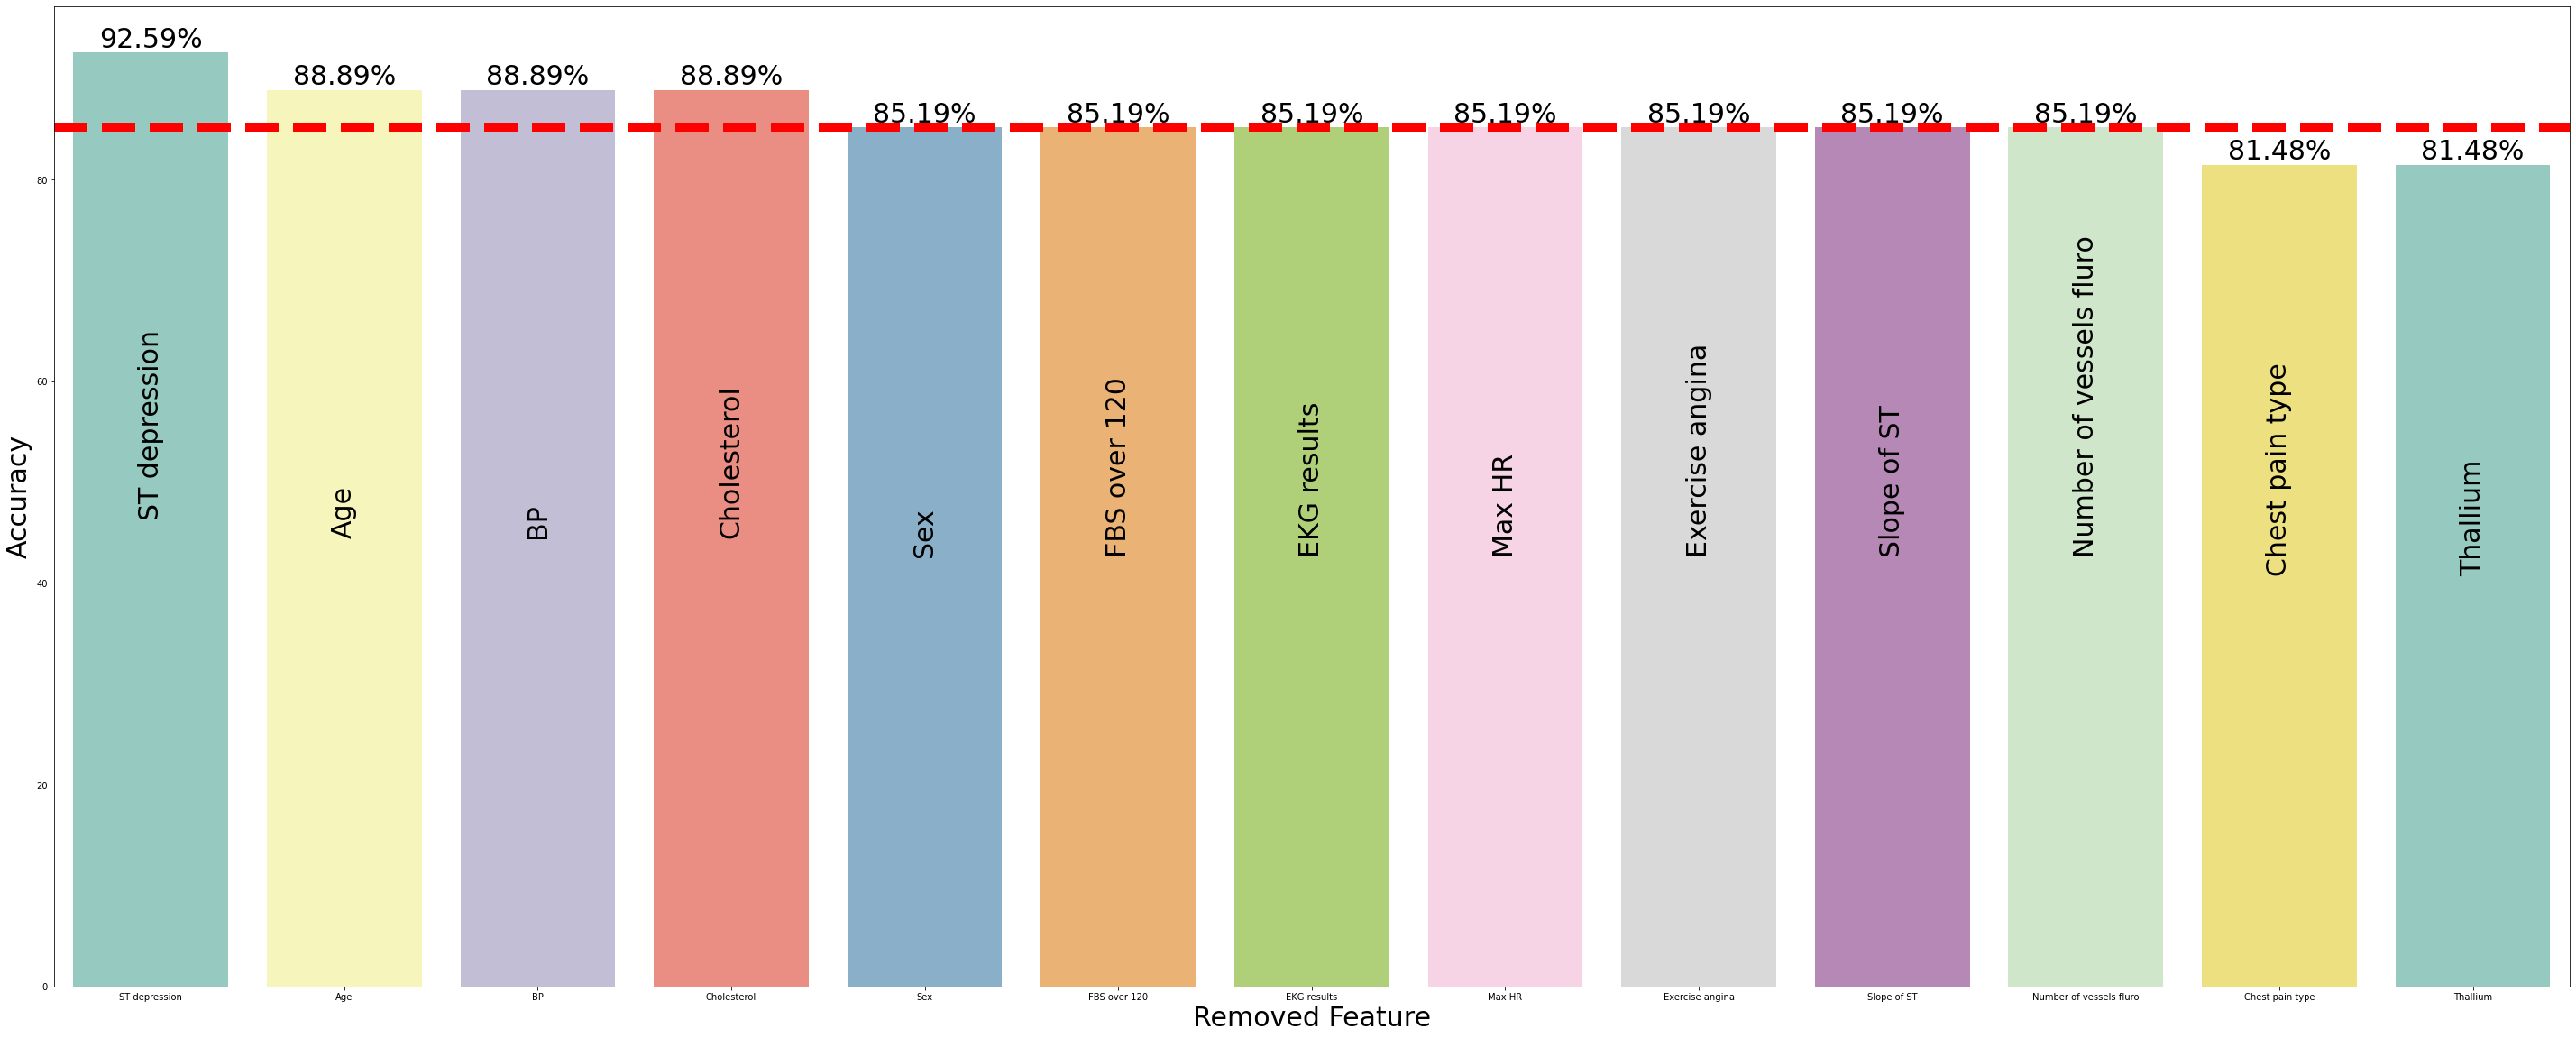

In [ ]:
new = pd.DataFrame(accuracy, index = [0])
plt.figure(figsize=(50,20))
new = new.sort_values(by=0, ascending=False, axis=1)
sns.barplot(data = new, palette = 'Set3')

plt.xlabel('Removed Feature',fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.axhline(log_all_accu, color = 'r', linewidth=10, linestyle = '--')

names = new.columns
m = range(len(names))
s = new.iloc[0]
for i in range(len(s)):
    plt.annotate((str(s[i]) +'%'), xy=(m[i],s[i]), ha='center', va='bottom', fontsize = 30)
    plt.annotate(new.columns[i], xy=(m[i],s[i]/2), ha='center', va='bottom',rotation = 90, fontsize = 30)